# Image Matching Techniques


Image similarity methods can be used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest related products.

This notebook outlines a series of techniques to perform image matching, ranging from image processing approaches to the increasing complexity of SNN's.

For the majority of these approaches the image dimensions need to be fixed, indicating there needs to be consideration of how to handle different orientations and sizes.

Typically most of these apprpaches need the object of interest to be > 20& of the total image size, if no, object detetection first pass triage may be required before comparing.

## Technique 1 - SSIM

Peak Signal to noise ratio does not account for blurring of an image. The same image with 3 levels of blur will have the same PSNR. This along with MSE is a pixel by pixel comparison whereas SSIM is more robust, accounting for a combination of correlation loss, luminance distortion and contrast distortion

In [43]:
from skimage.metrics import structural_similarity as ssim
import imutils
import cv2
import matplotlib.pyplot as plt

In [30]:
imageA = cv2.imread('../../data/images/1.jpg')
imageB = cv2.imread('../../data/images/2.jpg')

grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

grayA = cv2.resize(grayA, (100, 200)) 
grayB = cv2.resize(grayB, (100, 200)) 

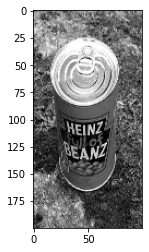

In [35]:
plt.imshow(grayA, cmap="gray")

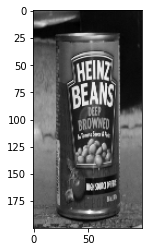

In [36]:
plt.imshow(grayB, cmap="gray")

In [31]:
(score, diff) = ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.047410974281702795


SSIM has some drawbacks:

- It is a mathmatical process that does not involve any direct learning, meaning it will be rigid to scale, rotation and other typical augmentations that will be expected in real world images.
- While it uses regions of the image and structure, it is still limited to variations art the pixel level.
- Images must also have the same dimensions.
- You can see above that you have the same product but with a low SSIM score, this is not accounting for discovery issues like false postive rates which can come into play as well. This is where a trained ML approach shines - in cases where the environment is not controlled.

## Technique 2 - CNN Embeddings + Similarity Measure

The majority of state-of-the-art systems for image similarity use DNNs to compute a representation of an image (e.g. a vector of 512 floating point values). The similarity between two images is then defined as the cosine or the L2 distance between their respective DNN representation

This is what this section represents - DNN -> Feature Vector -> Normamlisation -> Distance Measure.

The DNN is typically fine tuned form a larger dataset on a given domain.

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import os.path

In [40]:
#################################################
# This function:
# Loads the JPEG image at the given path
# Decodes the JPEG image to a uint8 W X H X 3 tensor
# Resizes the image to 224 x 224 x 3 tensor
# Returns the pre processed image as 224 x 224 x 3 tensor
#################################################
def load_img(path):
 img = tf.io.read_file(path)
 img = tf.io.decode_jpeg(img, channels=3)
 img = tf.image.resize_with_pad(img, 224, 224)
 img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]
 return img

In [50]:
#################################################
# This function:
# Loads the mobilenet model in TF.HUB
# Makes an inference for all images stored in a local folder
# Saves each of the feature vectors in a file
#################################################
def get_image_feature_vectors():
 
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    module = hub.load(module_handle)

    for filename in glob.glob('../../data/images/*.jpg'):

        print(filename)
        img = load_img(filename)
        features = module(img)
        feature_set = np.squeeze(features)

        outfile_name = os.path.basename(filename) + ".npz"
        out_path = os.path.join('C:/Users/jorda/Desktop/temp', outfile_name)

        np.savetxt(out_path, feature_set, delimiter=',')

get_image_feature_vectors()

../../data/images\1.jpg
../../data/images\2.jpg
../../data/images\3.jpg
../../data/images\4.jpg


The above using a MobileNet model, there may be better options to maintain resolution or have higher performing matching. Or a model trained on a more carefully chosen dataset and fine tuning on a domain dataset.

https://pypi.org/project/annoy/
https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509

In [51]:
file_vector_1 = np.loadtxt('C:/Users/jorda/Desktop/temp/1.jpg.npz')
file_vector_2 = np.loadtxt('C:/Users/jorda/Desktop/temp/2.jpg.npz')
file_vector_3 = np.loadtxt('C:/Users/jorda/Desktop/temp/3.jpg.npz')
file_vector_4 = np.loadtxt('C:/Users/jorda/Desktop/temp/4.jpg.npz')

In [54]:
import scipy

print(scipy.spatial.distance.cosine(file_vector_1, file_vector_2))
print(scipy.spatial.distance.cosine(file_vector_1, file_vector_3))
print(scipy.spatial.distance.cosine(file_vector_1, file_vector_4))

0.3247678497901003
0.40632251755042614
0.48345567282401414


**We can see that the distance increases as the images become less alike** A threshold will need considered as well.

We could extend this to use ANNOY (or other neighbour, cluster approach)

Annoy (Approximate Nearest Neighbor Oh Yeah), is an open-sourced library for approximate nearest neighbor implementation.

https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509


## Technique 3 - Micosoft/FastAI Approach.

We showed how to train a DNN and use its feature embeddings for image retrieval. In that notebook, the DNN was trained using a standard image classification loss. More accurate models are typically trained explicitly for image similarity using Triplet Learning such as the FaceNet paper. While triplet-based approaches achieve good accuracies, they are conceptually complex, slower, and more difficult to train/converge due to issue such as how to mine relevant triplets.

Instead, we implement the BMVC 2019 paper "Classification is a Strong Baseline for Deep Metric Learning" which shows that this extra overhead is not necessary. Indeed, by making small changes to standard classification DNNs, the authors achieve results which are comparable or better than the previous state-of-the-art.

In [3]:
import math, os, random, sys, torch
import numpy as np
from pathlib import Path
import torch.nn as nn
from IPython.core.debugger import set_trace

# Fast.ai
import fastai
from fastai.layers import FlattenedLoss
from fastai.vision import (
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
)

In [2]:
print(f"Fast.ai version = {fastai.__version__}")

Fast.ai version = 1.0.57


Hyperparameters and config.

In [ ]:
EPOCHS_HEAD = 2 #12 
EPOCHS_BODY = 2 #12
HEAD_LEARNING_RATE = 0.01   
BODY_LEARNING_RATE = 0.0001 
BATCH_SIZE = 32
IM_SIZE = (224,224)
DROPOUT = 0 
ARCHITECTURE = models.resnet50
EMBEDDING_DIM = 2048

Create a fast AI data bunch object

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
c:\users\jorda\desktop\machine-learning-blu

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
c:\users\jorda\desktop\machine-learning-blu

Data for fine-tuning: 62 training images and 3 validation images.


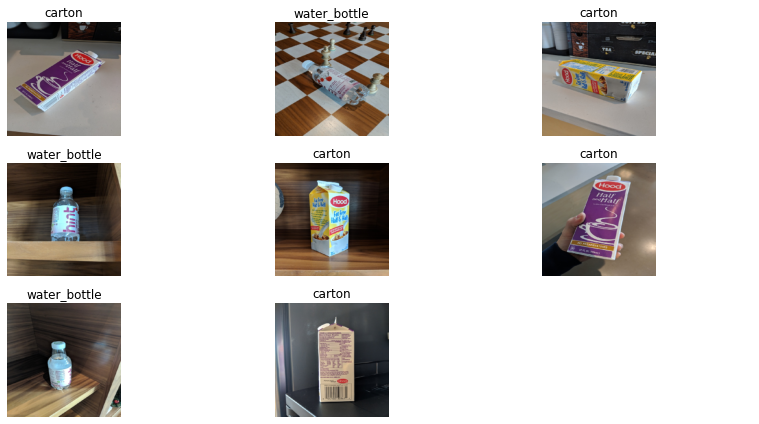

In [20]:
random.seed(642)
data_finetune = (
    ImageList.from_folder('../../data/images/fridgeObjectsImageRetrieval/train')
    .split_by_rand_pct(valid_pct=0.05, seed=20)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE)
    .normalize(imagenet_stats)
)

print(f"Data for fine-tuning: {len(data_finetune.train_ds.x)} training images and {len(data_finetune.valid_ds.x)} validation images.")
data_finetune.show_batch(rows=3, figsize=(12, 6))

The cell below implements the NormSoftmax loss and layers from the "Classification is a Strong Baseline for Deep Metric Learning" paper. Most of the code is taken from the official repository and only slightly modified to work within the fast.ai framework and to optionally use the 4096 dimensional embedding of the original ResNet-50 model.

In [21]:
class EmbeddedFeatureWrapper(nn.Module):
    """
    DNN head: pools, down-projects, and normalizes DNN features to be of unit length.
    """
    def __init__(self, input_dim, output_dim, dropout=0):
        super(EmbeddedFeatureWrapper, self).__init__()
        self.output_dim = output_dim
        self.dropout = dropout
        if output_dim != 4096:
            self.pool = nn.AdaptiveAvgPool2d(1)
        self.standardize = nn.LayerNorm(input_dim, elementwise_affine = False)
        self.remap = None
        if input_dim != output_dim:
           self.remap = nn.Linear(input_dim, output_dim, bias = False)
        if dropout > 0:
            self.dropout = nn.Dropout(dropout) 
    
    def forward(self, x):
        if self.output_dim != 4096:
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.standardize(x)
        if self.remap:
           x = self.remap(x)
        if self.dropout > 0:
            x = self.dropout(x)      
        x = nn.functional.normalize(x, dim=1)
        return x
    
    
class L2NormalizedLinearLayer(nn.Module):
    """
    Apply a linear layer to the input, where the weights are normalized to be of unit length.
    """
    def __init__(self, input_dim, output_dim):
        super(L2NormalizedLinearLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim))    
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        # Initialization from nn.Linear (https://github.com/pytorch/pytorch/blob/v1.0.0/torch/nn/modules/linear.py#L129)
        
    def forward(self, x):
        norm_weight = nn.functional.normalize(self.weight, dim=1)
        prediction_logits = nn.functional.linear(x, norm_weight)
        return prediction_logits
        

class NormSoftmaxLoss(nn.Module):
    """
    Apply temperature scaling on logits before computing the cross-entropy loss.
    """
    def __init__(self, temperature=0.05):
        super(NormSoftmaxLoss, self).__init__() 
        self.temperature = temperature
        self.loss_fn = nn.CrossEntropyLoss()
 
    def forward(self, prediction_logits, instance_targets):
        loss = self.loss_fn(prediction_logits / self.temperature, instance_targets)
        return loss

In [22]:
learn = cnn_learner(
    data_finetune,
    ARCHITECTURE,
    metrics=[],
    ps=DROPOUT 
)

print("** Original model head **")
print(learn.model[1])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\jorda/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

** Original model head **
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=2, bias=True)
)


The CNN is then modified to use the suggested "norm softmax loss" instead of the default cross-entropy loss:

In [23]:
# By default uses the 2048 dimensional pooling layer as implemented in the paper.
# Optionally can instead keep the 4096-dimensional pooling layer from the ResNet-50 model.
if EMBEDDING_DIM != 4096:
    modules = []
    pooling_dim = 2048
else:
    modules = [l for l in learn.model[1][:3]]
    pooling_dim = 4096
    
# Add new layers
modules.append(EmbeddedFeatureWrapper(input_dim=pooling_dim, 
                                      output_dim=EMBEDDING_DIM, 
                                      dropout=DROPOUT))
modules.append(L2NormalizedLinearLayer(input_dim=EMBEDDING_DIM, 
                                       output_dim=len(data_finetune.classes)))
learn.model[1] = nn.Sequential(*modules)

# Create new learner object since otherwise the new layers are not updated during backprop 
learn = fastai.vision.Learner(data_finetune, learn.model)

# Update loss function
learn.loss_func = FlattenedLoss(NormSoftmaxLoss)

print("\n** Edited model head **")
print(learn.model[1])


** Edited model head **
Sequential(
  (0): EmbeddedFeatureWrapper(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (standardize): LayerNorm((2048,), eps=1e-05, elementwise_affine=False)
  )
  (1): L2NormalizedLinearLayer()
)


Similar to the classification notebooks we first refine the head and then the full CNN.

In [25]:
learn.fit_one_cycle(EPOCHS_HEAD, HEAD_LEARNING_RATE)

epoch,train_loss,valid_loss,time
0,0.139047,0.000003,01:44
1,0.070207,0.000009,01:40
2,0.155464,3.536223,01:41
3,0.244465,0.016655,01:39
4,0.432824,0.000211,01:42
5,0.389694,0.000111,01:40


In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(EPOCHS_BODY, BODY_LEARNING_RATE)

epoch,train_loss,valid_loss,time
0,0.302271,0.000013,01:56
1,0.216661,0.070832,01:55
2,0.189856,0.764293,01:56
3,0.150965,0.127921,02:03
4,0.140718,0.117748,01:58
5,0.108404,0.077780,01:58


Now, load the test dataset and show some samples.

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
c:\users\jorda\desktop\machine-learning-blu

Data for retrieval evaluation: 69 images.


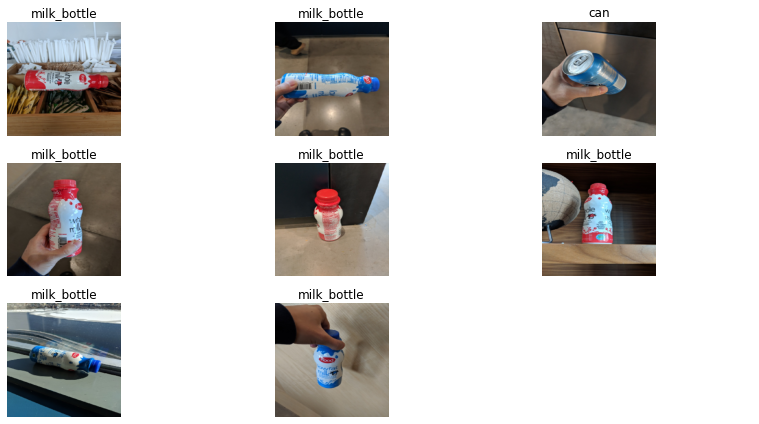

In [30]:
data_rank = (
    ImageList.from_folder('../../data/images/fridgeObjectsImageRetrieval/test')
    .split_none()
    .label_from_folder()
    .transform(size=IM_SIZE) 
    .databunch(bs=BATCH_SIZE)
    .normalize(imagenet_stats)
)

print(f"Data for retrieval evaluation: {len(data_rank.train_ds.x)} images.")

# Display example images
data_rank.show_batch(rows=3, figsize=(12, 6))

Get the feature vectors for the new dataset - the function elow is a copy / paste from MSFT utils.

In [38]:
from fastai.basic_train import Learner
from torch.nn import Module
from typing import List, Dict
from torch import Tensor


class SaveFeatures:
    features = None

    def __init__(self, model_layer: Module):
        self.hook = model_layer.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module: Module, input: Tensor, output: Tensor):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))

    def remove(self):
        self.hook.remove()

def compute_features_learner(
    data, dataset_type: DatasetType, learn: Learner, embedding_layer: Module) -> List[Dict[str, np.array]]:

    if dataset_type == DatasetType.Train or dataset_type == DatasetType.Fix:
        dataset_type = (
            DatasetType.Fix
        )  # Training set without shuffeling and no dropping of last batch. See note above.
        label_list = list(data.train_ds.items)
    elif dataset_type == DatasetType.Valid:
        label_list = list(data.valid_ds.items)
    elif dataset_type == DatasetType.Test:
        label_list = list(data.test_ds.items)
    else:
        raise Exception(
            "Dataset_type needs to be of type DatasetType.Train, DatasetType.Valid, DatasetType.Test or DatasetType.Fix."
        )

    # Update what data the learner object is using
    tmp_data = learn.data
    learn.data = data

    # Compute features
    featurizer = SaveFeatures(embedding_layer)
    learn.get_preds(dataset_type)
    feats = featurizer.features[:]

    # Set data back to before
    learn.data = tmp_data

    # Get corresponding image paths
    assert len(feats) == len(label_list)
    im_paths = [str(x) for x in label_list]
    return dict(zip(im_paths, feats))

In [39]:
embedding_layer = learn.model[1][-2]
dnn_features = compute_features_learner(data_rank, DatasetType.Train, learn, embedding_layer)

Perform image retrieval againt the ranking set...

In [54]:
query_im_path =  str(data_rank.train_ds.items[1])
query_feature = dnn_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")

Query image path: ..\..\data\images\fridgeObjectsImageRetrieval\test\can\10.jpg
Query feature dimension: 2048


In [55]:
query_feature

array([-0.021536, -0.023597, -0.017223, -0.015434, ..., -0.016282, -0.013356,  0.004462, -0.014663], dtype=float32)

In [67]:
import scipy
print(scipy.spatial.distance.cosine(query_feature, dnn_features[str(data_rank.train_ds.items[6])]))
print(scipy.spatial.distance.cosine(query_feature, dnn_features[str(data_rank.train_ds.items[51])]))

0.46021848917007446
0.7716980129480362


We can see the cosine distance respects the different between the two object types, even when partially fine tuned on a small dataset.

### Evaluation Procedure

We use a blunt copy and paste of a microsoft helper function for computing distance across a complete set of DNN features to a query image. Modified to use cosine distance only in the loop.

In [75]:
def compute_distances(
    query_feature: np.array, feature_dict: dict) -> List:
    distances = []
    for im_path, feature in feature_dict.items():
        distance = scipy.spatial.distance.cosine(query_feature, feature)
        distances.append((im_path, distance))
    return distances

In [76]:
count = 0
labels = data_rank.train_ds.y
im_paths = data_rank.train_ds.items

# Use a subset of at least 500 images from the ranking set as query images.
step = math.ceil(len(im_paths)/500.0)
query_indices = range(len(im_paths))[::step]

# Loop over all query images
for query_index in query_indices:
    if query_index+1 % (step*100) == 0:
        print(query_index, len(im_paths))

    # Get the DNN features of the query image
    query_im_path =  str(im_paths[query_index])
    query_feature = dnn_features[query_im_path]
    
    # Compute distance to all images in the gallery set. 
    distances = compute_distances(query_feature, dnn_features)

    # Find the image with smallest distance
    min_dist = float('inf')
    min_dist_index = None
    for index, distance in enumerate(distances):
        if index != query_index: #ignore the query image itself
            if distance[1] < min_dist:
                min_dist = distance[1]
                min_dist_index = index

    # Count how often the image with smallest distance has the same label as the query
    if labels[query_index] == labels[min_dist_index]:
        count += 1

In [77]:
recallAt1 = 100.0 * count / len(query_indices)
print("Recall@1 = {:2.2f}".format(recallAt1))

Recall@1 = 76.81


**notes**

- This method using a resnet model, there may be variation in options we can play with around vector dimensions and layer selection for the feature vector.

- This notebook does not use Microsofts utility package directly, some of which may be useful to refer to if expanding.

- The MSFT eval uses a more effecient version that have built themselves.

## Technique 4 - Auto Encoders

Train and encoder decoder model, with a vector representation in the centre of the network.

TODO

## Technique 3 - Siamese Neural Networks (1)

## Technique 4 - Siamese Neural Networks (2) - Triplet Learning

## Technique 5 - Facebook Faiss

## Resources

- https://medium.com/@datamonsters/a-quick-overview-of-methods-to-measure-the-similarity-between-images-f907166694ee
- https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/
- https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
- https://github.com/microsoft/computervision-recipes/tree/master/scenarios/similarity
- https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509